In [4]:

from gensim.corpora import Dictionary
from gensim.models import ldamodel
import numpy
%matplotlib inline

C:\Users\ADMIN\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [5]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [6]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [7]:
fp = "F:datasets/pubnew.csv"
df = pd.read_csv(fp)
#print(df.content.unique())# Convert to list
data = df.content.values.tolist()
# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]
# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])
df.head()

['Matrix rank based ontology matching: An extension of string equality '
 'matchingIn this article, a string-based algorithm and the analogy of the '
 'total number of deviations that exist between two matrices are used for '
 'ontology matching. The type of matching and the distance between them are '
 'derived from the rank of the matrix. This process is useful for an agent '
 'programme to extract the knowledge from the application domain and to '
 'evaluate the result of matching to decide whether to include or exclude the '
 'ontology. As a case study to demonstrate the developed algorithm, the Fast '
 'Breeder Test Reactor (FBTR) is taken for analysis by representing its '
 'components, such as the steam generator system and the control rod drive '
 'mechanism, in formats such as RDF (Resource Description Framework) and OWL '
 '(Web Ontology Language).']


,content
0,Matrix rank based ontology matching: An extens...
1,Sputtered AZO Thin Films for TCO and Back Refl...
2,Assessment of natural radioactivity and radiol...
3,Accelerated rusting of reinforcing bars: The r...
4,Comparison of phase interaction models for hig...


In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['matrix', 'rank', 'based', 'ontology', 'matching', 'an', 'extension', 'of', 'string', 'equality', 'matchingin', 'this', 'article', 'string', 'based', 'algorithm', 'and', 'the', 'analogy', 'of', 'the', 'total', 'number', 'of', 'deviations', 'that', 'exist', 'between', 'two', 'matrices', 'are', 'used', 'for', 'ontology', 'matching', 'the', 'type', 'of', 'matching', 'and', 'the', 'distance', 'between', 'them', 'are', 'derived', 'from', 'the', 'rank', 'of', 'the', 'matrix', 'this', 'process', 'is', 'useful', 'for', 'an', 'agent', 'programme', 'to', 'extract', 'the', 'knowledge', 'from', 'the', 'application', 'domain', 'and', 'to', 'evaluate', 'the', 'result', 'of', 'matching', 'to', 'decide', 'whether', 'to', 'include', 'or', 'exclude', 'the', 'ontology', 'as', 'case', 'study', 'to', 'demonstrate', 'the', 'developed', 'algorithm', 'the', 'fast', 'breeder', 'test', 'reactor', 'fbtr', 'is', 'taken', 'for', 'analysis', 'by', 'representing', 'its', 'components', 'such', 'as', 'the', 'steam',

In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  


C:\Users\ADMIN\Anaconda3\lib\site-packages\gensim\models\phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [10]:
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)


In [11]:
# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['matrix', 'rank', 'based', 'ontology', 'matching', 'an', 'extension', 'of', 'string', 'equality', 'matchingin', 'this', 'article', 'string', 'based', 'algorithm', 'and', 'the', 'analogy', 'of', 'the', 'total', 'number', 'of', 'deviations', 'that', 'exist', 'between', 'two', 'matrices', 'are', 'used', 'for', 'ontology', 'matching', 'the', 'type', 'of', 'matching', 'and', 'the', 'distance', 'between', 'them', 'are', 'derived', 'from', 'the', 'rank', 'of', 'the', 'matrix', 'this', 'process', 'is', 'useful', 'for', 'an', 'agent', 'programme', 'to', 'extract', 'the', 'knowledge', 'from', 'the', 'application', 'domain', 'and', 'to', 'evaluate', 'the', 'result', 'of', 'matching', 'to', 'decide', 'whether', 'to', 'include', 'or', 'exclude', 'the', 'ontology', 'as', 'case', 'study', 'to', 'demonstrate', 'the', 'developed', 'algorithm', 'the', 'fast_breeder_test', 'reactor_fbtr', 'is', 'taken', 'for', 'analysis', 'by', 'representing', 'its', 'components', 'such', 'as', 'the', 'steam', 'generato

In [12]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [13]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['matrix', 'rank', 'base', 'ontology', 'match', 'extension', 'string', 'equality', 'matchingin', 'article', 'string', 'base', 'algorithm', 'analogy', 'total', 'number', 'deviation', 'exist', 'matrix', 'use', 'ontology', 'match', 'type', 'matching', 'distance', 'derive', 'rank', 'matrix', 'process', 'useful', 'agent', 'programme', 'extract', 'knowledge', 'application', 'domain', 'evaluate', 'result', 'matching', 'decide', 'include', 'exclude', 'ontology', 'case', 'study', 'demonstrate', 'develop', 'algorithm', 'fast_breeder', 'test', 'take', 'analysis', 'represent', 'component', 'steam', 'generator', 'system', 'control', 'rod', 'drive', 'mechanism', 'format', 'rdf', 'resource', 'description', 'framework', 'owl', 'web', 'ontology', 'language']]


In [14]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 2), (33, 2), (34, 1), (35, 3), (36, 1), (37, 1), (38, 4), (39, 1), (40, 1), (41, 1), (42, 2), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 2), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1)]]


In [15]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('agent', 1),
  ('algorithm', 2),
  ('analogy', 1),
  ('analysis', 1),
  ('application', 1),
  ('article', 1),
  ('base', 2),
  ('case', 1),
  ('component', 1),
  ('control', 1),
  ('decide', 1),
  ('demonstrate', 1),
  ('derive', 1),
  ('description', 1),
  ('develop', 1),
  ('deviation', 1),
  ('distance', 1),
  ('domain', 1),
  ('drive', 1),
  ('equality', 1),
  ('evaluate', 1),
  ('exclude', 1),
  ('exist', 1),
  ('extension', 1),
  ('extract', 1),
  ('fast_breeder', 1),
  ('format', 1),
  ('framework', 1),
  ('generator', 1),
  ('include', 1),
  ('knowledge', 1),
  ('language', 1),
  ('match', 2),
  ('matching', 2),
  ('matchingin', 1),
  ('matrix', 3),
  ('mechanism', 1),
  ('number', 1),
  ('ontology', 4),
  ('owl', 1),
  ('process', 1),
  ('programme', 1),
  ('rank', 2),
  ('rdf', 1),
  ('represent', 1),
  ('resource', 1),
  ('result', 1),
  ('rod', 1),
  ('steam', 1),
  ('string', 2),
  ('study', 1),
  ('system', 1),
  ('take', 1),
  ('test', 1),
  ('total', 1),
  ('type', 1

In [85]:
n=34
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           iterations=10000,
                                           alpha='auto',
                                           per_word_topics=True              
                                           ) 

In [86]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(1,
  '0.019*"tio_nanotube" + 0.017*"photocatalytic" + 0.016*"heterojunction" + '
  '0.014*"anatase_rutile" + 0.013*"peg" + 0.010*"present" + 0.010*"mos_odt" + '
  '0.010*"znonp" + 0.010*"mnc" + 0.010*"vacancy"'),
 (13,
  '0.052*"model" + 0.040*"obtain" + 0.035*"initial" + 0.031*"non" + '
  '0.030*"downward" + 0.026*"fese" + 0.023*"nitrate" + 0.020*"good_agreement" '
  '+ 0.019*"experimental" + 0.018*"quench"'),
 (8,
  '0.034*"field" + 0.031*"pb" + 0.023*"system" + 0.021*"ferromagnetic" + '
  '0.018*"base" + 0.017*"mno" + 0.016*"partial" + 0.013*"biotin" + '
  '0.013*"lawsone" + 0.013*"applicationsart"'),
 (7,
  '0.091*"alloy" + 0.036*"use" + 0.034*"anneal" + 0.032*"technique" + '
  '0.024*"implant" + 0.022*"positron" + 0.020*"metallic" + 0.020*"artifact" + '
  '0.019*"od" + 0.016*"suppression"'),
 (33,
  '0.044*"behavior" + 0.039*"equation" + 0.038*"self" + 0.038*"quantum" + '
  '0.034*"respect" + 0.018*"ground_state" + 0.017*"porous" + 0.015*"teo" + '
  '0.013*"temperature" + 0.011*

In [18]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.859921792383087

Coherence Score:  0.41096643253406545


In [19]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

C:\Users\ADMIN\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.178746  0.011444       1        1  15.649308
6     -0.210062  0.058042       2        1  12.059377
0     -0.190824  0.049933       3        1  10.456695
13    -0.107834 -0.178428       4        1   8.359533
11    -0.014638  0.086884       5        1   8.244066
9     -0.033243  0.078857       6        1   6.834092
14     0.050115 -0.062823       7        1   6.207593
8      0.010615 -0.183120       8        1   5.414674
1      0.135223 -0.095060       9        1   5.153604
7      0.093686 -0.102301      10        1   4.996196
12     0.089568  0.145495      11        1   4.427681
5     -0.017201  0.023113      12        1   4.351706
3      0.079368  0.025881      13        1   3.304200
10     0.163967  0.082156      14        1   2.352240
2      0.130007  0.059926      15        1   2.189034, topic_info=     Category        Freq              Term       Total  loglift  logprob
term                                                                     
254   Default  259.000000             phase  259.000000  30.0000  30.0000
267   Default  379.000000       temperature  379.000000  29.0000  29.0000
1622  Default  157.000000          magnetic  157.000000  28.0000  28.0000
213   Default  169.000000             steel  169.000000  27.0000  27.0000
3327  Default  101.000000             creep  101.000000  26.0000  26.0000
328   Default   95.000000             plate   95.000000  25.0000  25.0000
53    Default  118.000000              test  118.000000  24.0000  24.0000
92    Default  249.000000          property  249.000000  23.0000  23.0000
359   Default   69.000000              weld   69.000000  22.0000  22.0000
2509  Default   89.000000            strain   89.000000  21.0000  21.0000
4693  Default   72.000000               jet   72.000000  20.0000  20.0000
1827  Default   78.000000          strength   78.000000  19.0000  19.0000
379   Default  109.000000               ion  109.000000  18.0000  18.0000
160   Default  160.000000          material  160.000000  17.0000  17.0000
351   Default  179.000000         structure  179.000000  16.0000  16.0000
84    Default  192.000000          increase  192.000000  15.0000  15.0000
2110  Default   71.000000            stress   71.000000  14.0000  14.0000
78    Default   95.000000              film   95.000000  13.0000  13.0000
257   Default  122.000000          pressure  122.000000  12.0000  12.0000
1201  Default  105.000000        transition  105.000000  11.0000  11.0000
199   Default   68.000000             alloy   68.000000  10.0000  10.0000
4133  Default   52.000000  ball_indentation   52.000000   9.0000   9.0000
353   Default   71.000000           thermal   71.000000   8.0000   8.0000
3167  Default   60.000000       deformation   60.000000   7.0000   7.0000
108   Default  127.000000         technique  127.000000   6.0000   6.0000
1028  Default   41.000000         evolution   41.000000   5.0000   5.0000
3095  Default   48.000000           coating   48.000000   4.0000   4.0000
1844  Default   66.000000      nanoparticle   66.000000   3.0000   3.0000
736   Default   92.000000             metal   92.000000   2.0000   2.0000
163   Default  114.000000            method  114.000000   1.0000   1.0000
...       ...         ...               ...         ...      ...      ...
2145  Topic15    6.561429          adaptive    7.571711   3.6785  -4.9838
1539  Topic15    6.481624                li    7.491903   3.6769  -4.9960
5114  Topic15    6.448448         breathing    7.458728   3.6762  -5.0012
4085  Topic15    6.204111             tribo    7.214391   3.6708  -5.0398
5133  Topic15    5.535480            wander    6.545760   3.6541  -5.1538
5679  Topic15    5.535480        boson_peak    6.545760   3.6541  -5.1538
5113  Topic15    5.535480           breathe    6.545760   3.6541  -5.1538
613   Topic15   10.425680           network   12.416473   3.6470  -4.5207
5111 

In [80]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word,random_state=10,chunksize=100,iterations=10000)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [81]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=25, limit=50, step=1)

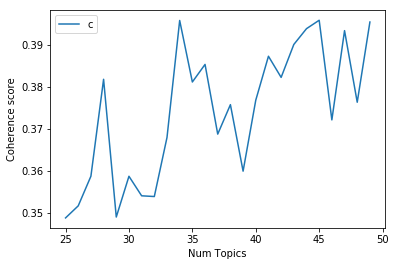

In [82]:
# Show graph
limit=50; start=25; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [83]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 25  has Coherence Value of 0.3488
Num Topics = 26  has Coherence Value of 0.3516
Num Topics = 27  has Coherence Value of 0.3587
Num Topics = 28  has Coherence Value of 0.3818
Num Topics = 29  has Coherence Value of 0.349
Num Topics = 30  has Coherence Value of 0.3587
Num Topics = 31  has Coherence Value of 0.354
Num Topics = 32  has Coherence Value of 0.3539
Num Topics = 33  has Coherence Value of 0.3679
Num Topics = 34  has Coherence Value of 0.3958
Num Topics = 35  has Coherence Value of 0.3812
Num Topics = 36  has Coherence Value of 0.3854
Num Topics = 37  has Coherence Value of 0.3687
Num Topics = 38  has Coherence Value of 0.3758
Num Topics = 39  has Coherence Value of 0.3599
Num Topics = 40  has Coherence Value of 0.3768
Num Topics = 41  has Coherence Value of 0.3873
Num Topics = 42  has Coherence Value of 0.3823
Num Topics = 43  has Coherence Value of 0.3901
Num Topics = 44  has Coherence Value of 0.3939
Num Topics = 45  has Coherence Value of 0.3959
Num Topics = 46

In [39]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.008*"study" + 0.007*"use" + 0.007*"phase" + 0.007*"temperature" + '
  '0.006*"increase" + 0.005*"result" + 0.005*"show" + 0.005*"extraction" + '
  '0.005*"method" + 0.004*"high"'),
 (1,
  '0.011*"use" + 0.009*"study" + 0.008*"temperature" + 0.008*"phase" + '
  '0.007*"high" + 0.005*"technique" + 0.005*"property" + 0.004*"surface" + '
  '0.004*"show" + 0.004*"different"'),
 (2,
  '0.014*"use" + 0.010*"study" + 0.007*"temperature" + 0.006*"find" + '
  '0.005*"phase" + 0.005*"sample" + 0.005*"high" + 0.004*"increase" + '
  '0.004*"steel" + 0.004*"value"'),
 (3,
  '0.010*"high" + 0.010*"temperature" + 0.009*"study" + 0.007*"use" + '
  '0.006*"property" + 0.005*"phase" + 0.005*"structure" + 0.004*"base" + '
  '0.004*"material" + 0.004*"present"'),
 (4,
  '0.010*"use" + 0.006*"study" + 0.006*"steel" + 0.006*"temperature" + '
  '0.005*"creep" + 0.004*"property" + 0.004*"method" + 0.004*"base" + '
  '0.004*"effect" + 0.004*"concentration"')]


In [40]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)
#print(df_dominant_topic)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.9885,"study, use, phase, temperature, increase, resu...",Matrix rank based ontology matching: An extens...
1,1,3.0,0.9901,"high, temperature, study, use, property, phase...",Sputtered AZO Thin Films for TCO and Back Refl...
2,2,3.0,0.9943,"high, temperature, study, use, property, phase...",Assessment of natural radioactivity and radiol...
3,3,3.0,0.9633,"high, temperature, study, use, property, phase...",Accelerated rusting of reinforcing bars: The r...
4,4,3.0,0.6210,"high, temperature, study, use, property, phase...",Comparison of phase interaction models for hig...
5,5,2.0,0.8836,"use, study, temperature, find, phase, sample, ...",Numerical simulation of Post Accident Heat Rem...
6,6,0.0,0.9897,"study, use, phase, temperature, increase, resu...",Transport phenomena in the electrodeionization...
7,7,3.0,0.9930,"high, temperature, study, use, property, phase...",Fixed bed adsorption of fluoride by Artocarpus...
8,8,2.0,0.7157,"use, study, temperature, find, phase, sample, ...",Physicochemical properties of PUREX solvent on...
9,9,0.0,0.9889,"study, use, phase, temperature, increase, resu...",Kinetics of interphase transfer of zirconium b...


In [26]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,8.0,"use, study, high, result, property, temperatur...",23.0,0.0541
1,17.0,"film, property, substrate, temperature, increa...",27.0,0.0635
2,15.0,"high, study, temperature, property, phase, use...",21.0,0.0494
3,4.0,"study, use, temperature, process, phase, condi...",15.0,0.0353
4,7.0,"steel, study, high, temperature, use, increase...",16.0,0.0376
5,13.0,"temperature, use, study, property, creep, phas...",30.0,0.0706
6,12.0,"phase, study, use, show, concentration, result...",28.0,0.0659
7,0.0,"use, temperature, find, pressure, show, high, ...",30.0,0.0706
8,7.0,"steel, study, high, temperature, use, increase...",28.0,0.0659
9,5.0,"use, property, study, weld, temperature, fatig...",11.0,0.0259


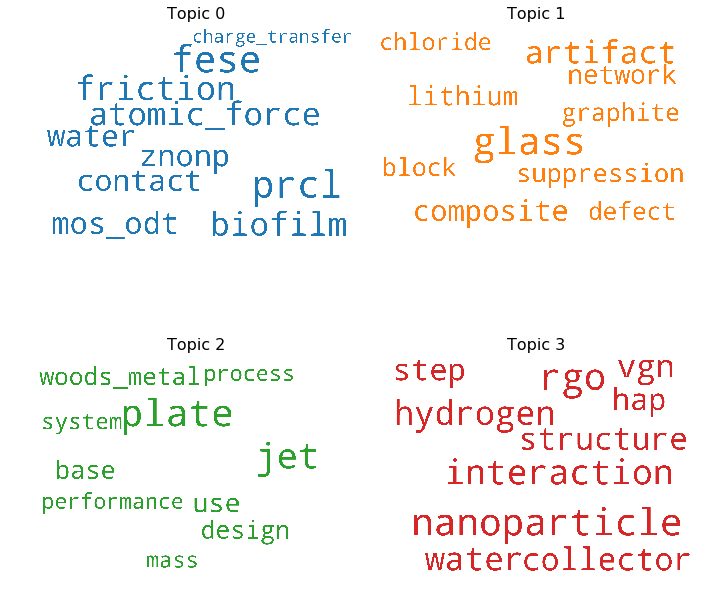

In [27]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()


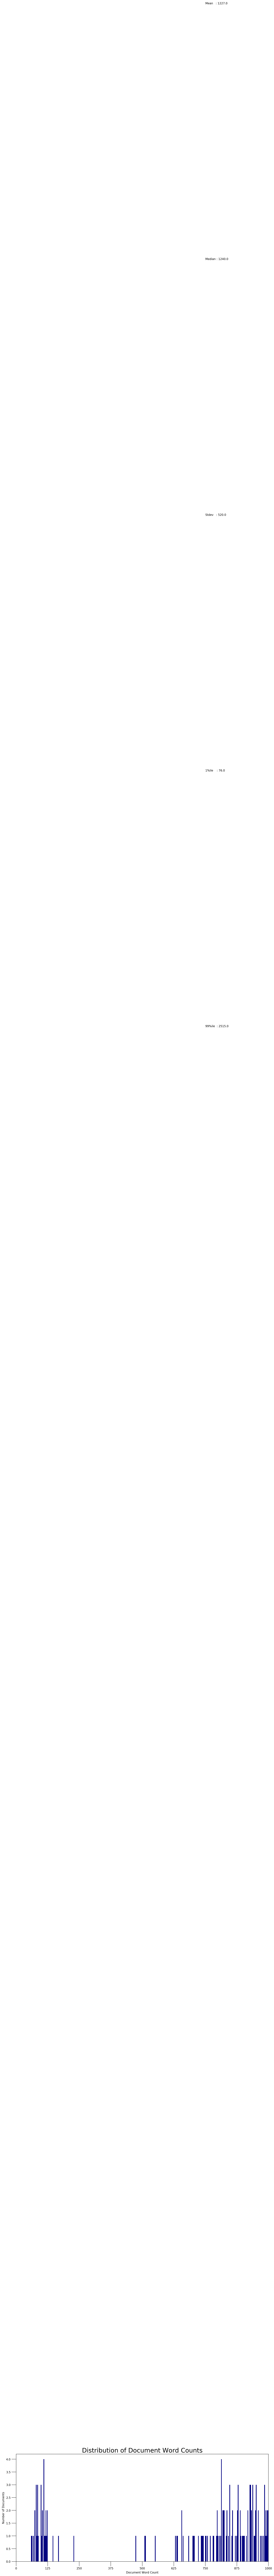

In [28]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

C:\Users\ADMIN\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


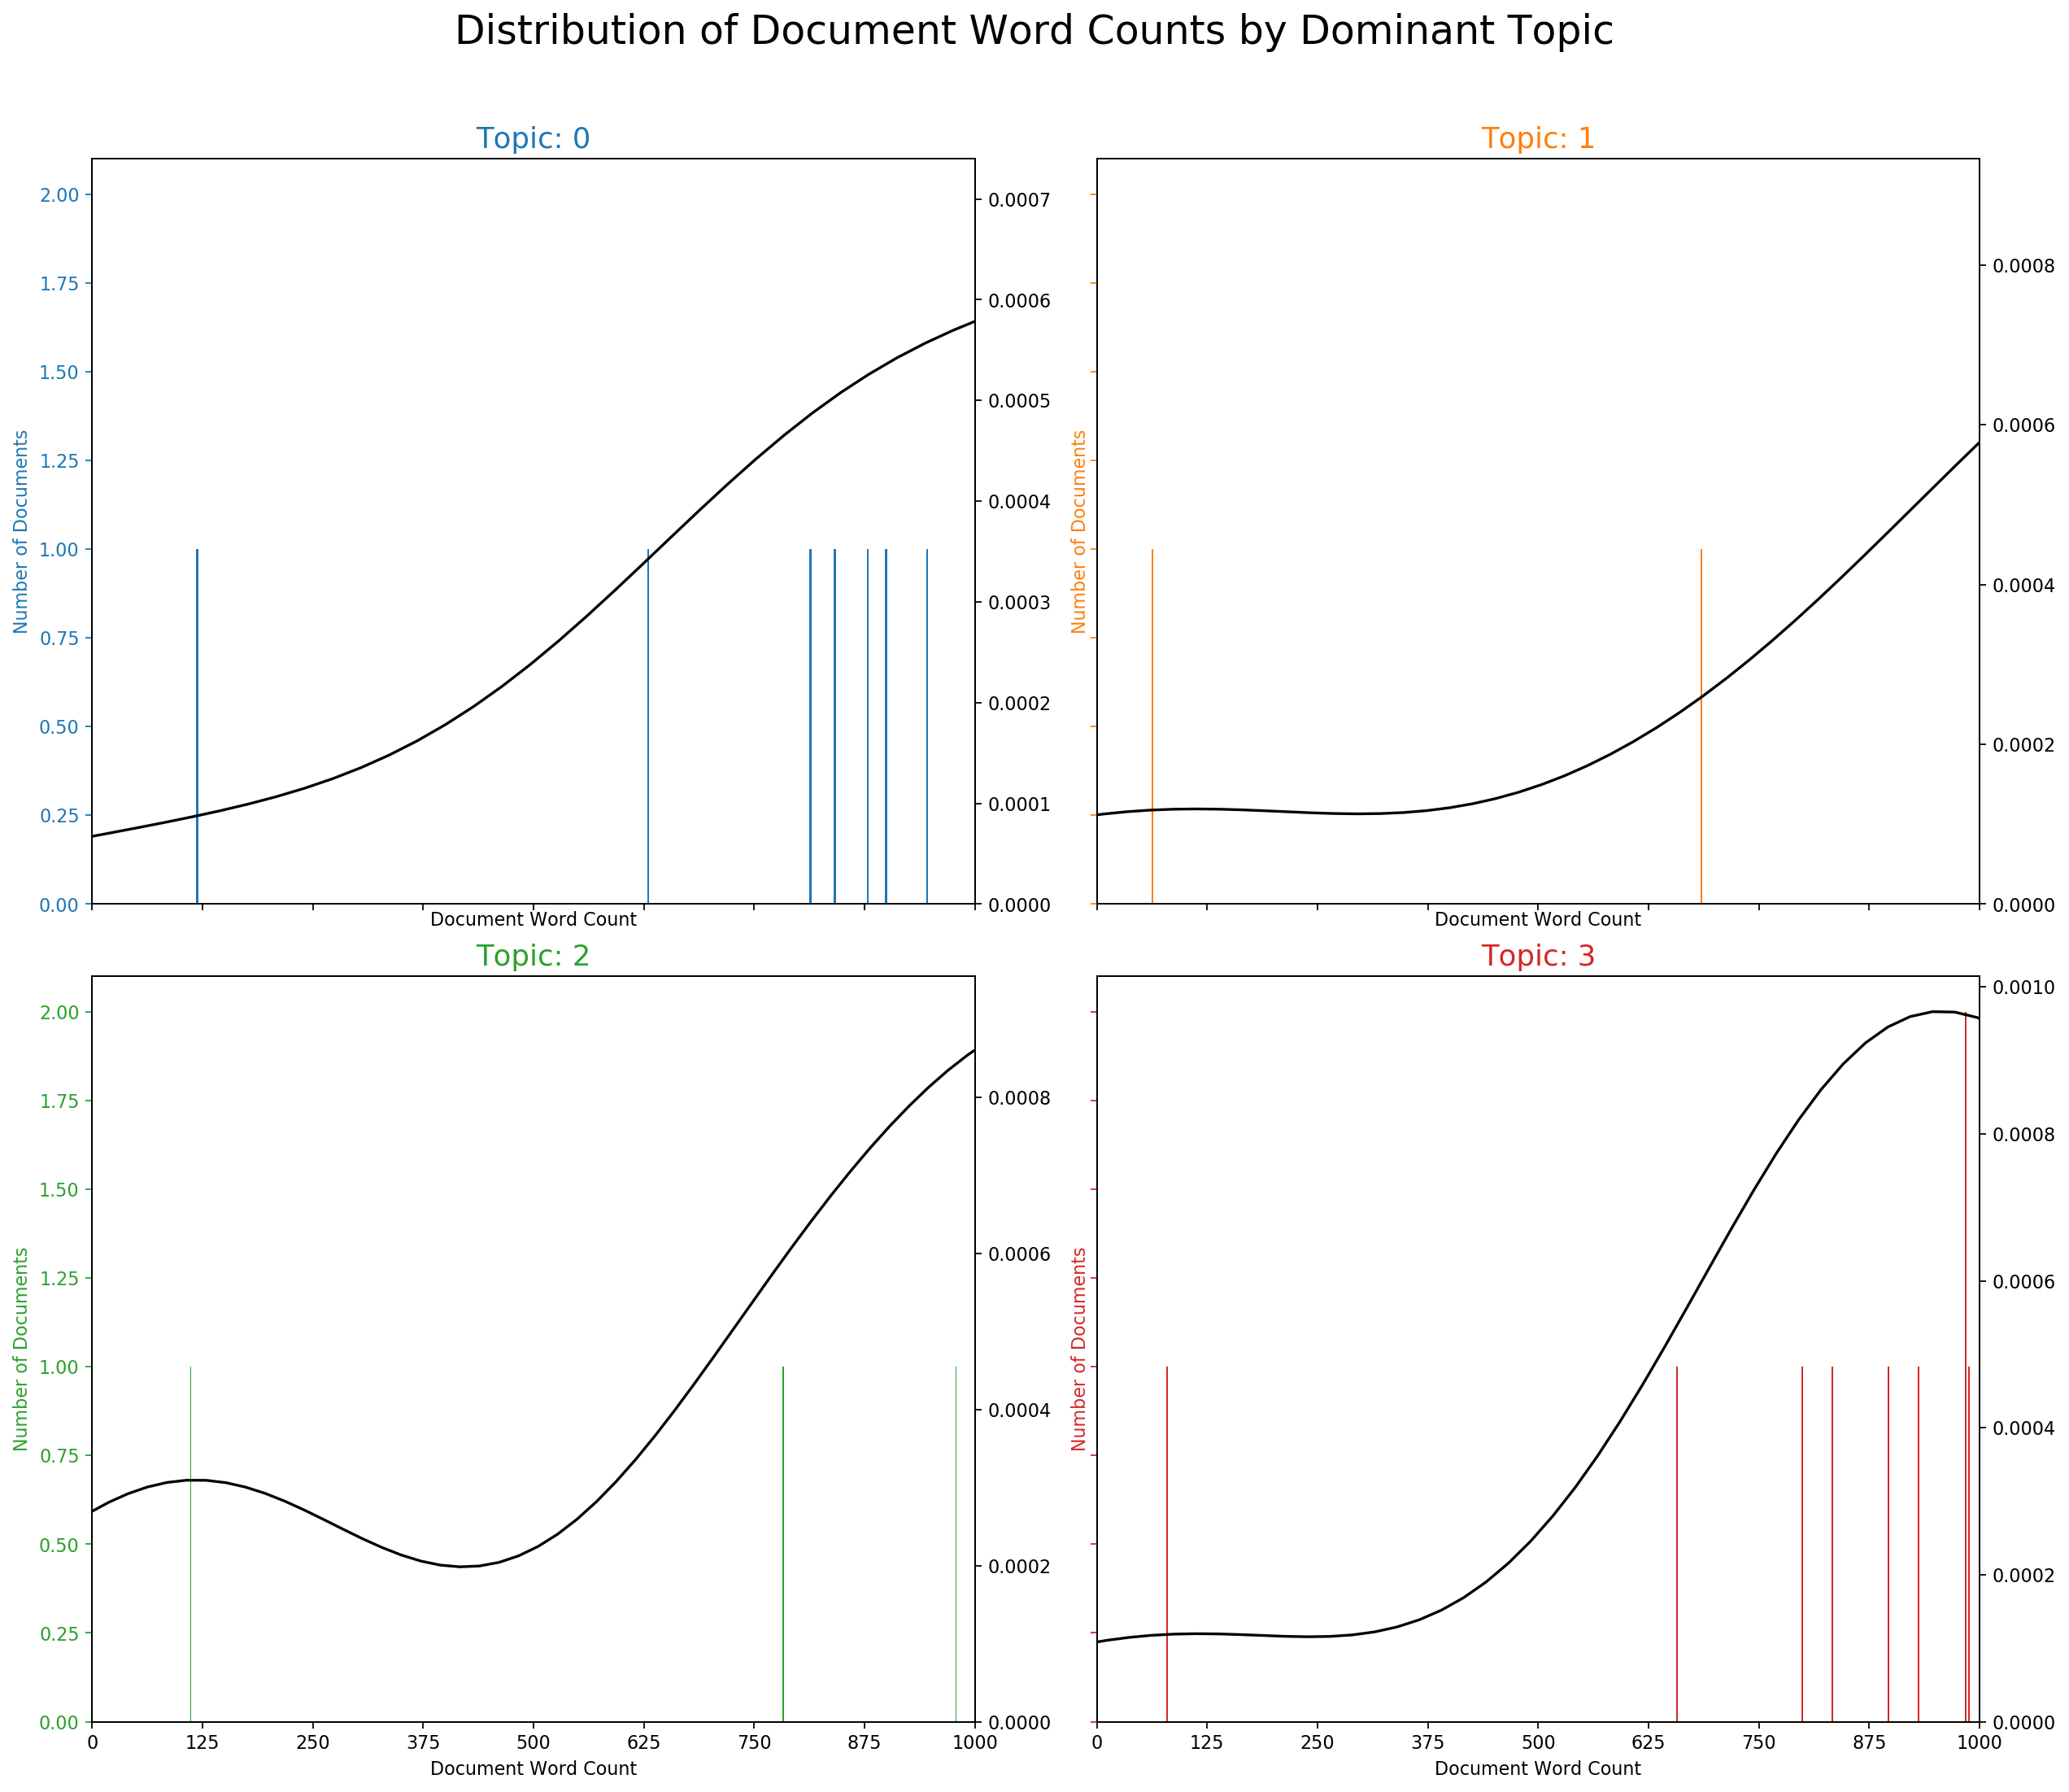

In [32]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

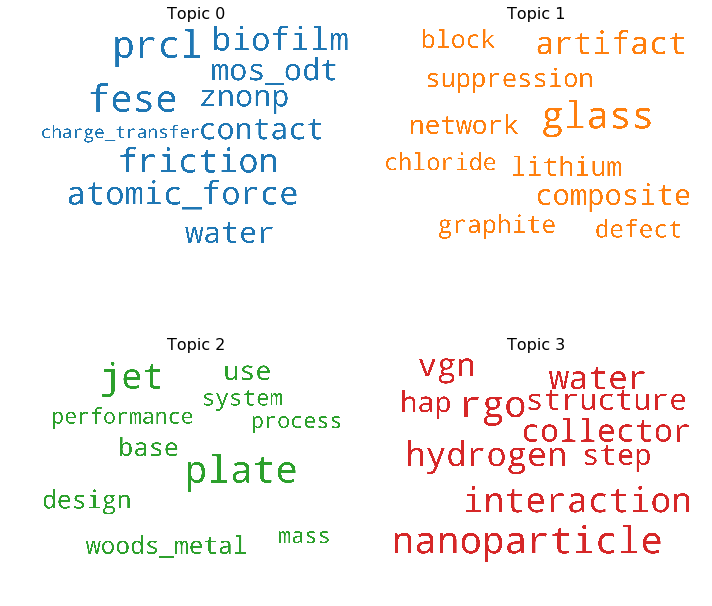

In [40]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [37]:
import sys
!conda install --yes --prefix {sys.prefix} numpy

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\ADMIN\Anaconda3

  added / updated specs:
    - numpy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2018.03.07 |                0         155 KB
    certifi-2018.11.29         |           py37_0         146 KB
    openssl-1.1.1a             |       he774522_0         5.7 MB
    ------------------------------------------------------------
                                           Total:         6.0 MB

The following packages will be SUPERSEDED by a higher-priority channel:

  ca-certificates                                  anaconda --> pkgs/main
  certifi                                          anaconda --> pkgs/main
  openssl                                          anaconda --> pkgs/main




certifi-2018.11.29   | 146 KB    |            |   0% 
certifi-2018.11.29   | 146 

In [39]:
import sys
!conda install -c conda-forge wordcloud  

Solving environment: ...working... done

# All requested packages already installed.



In [41]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

NameError: name 'data_ready' is not defined

IndexError: list index out of range

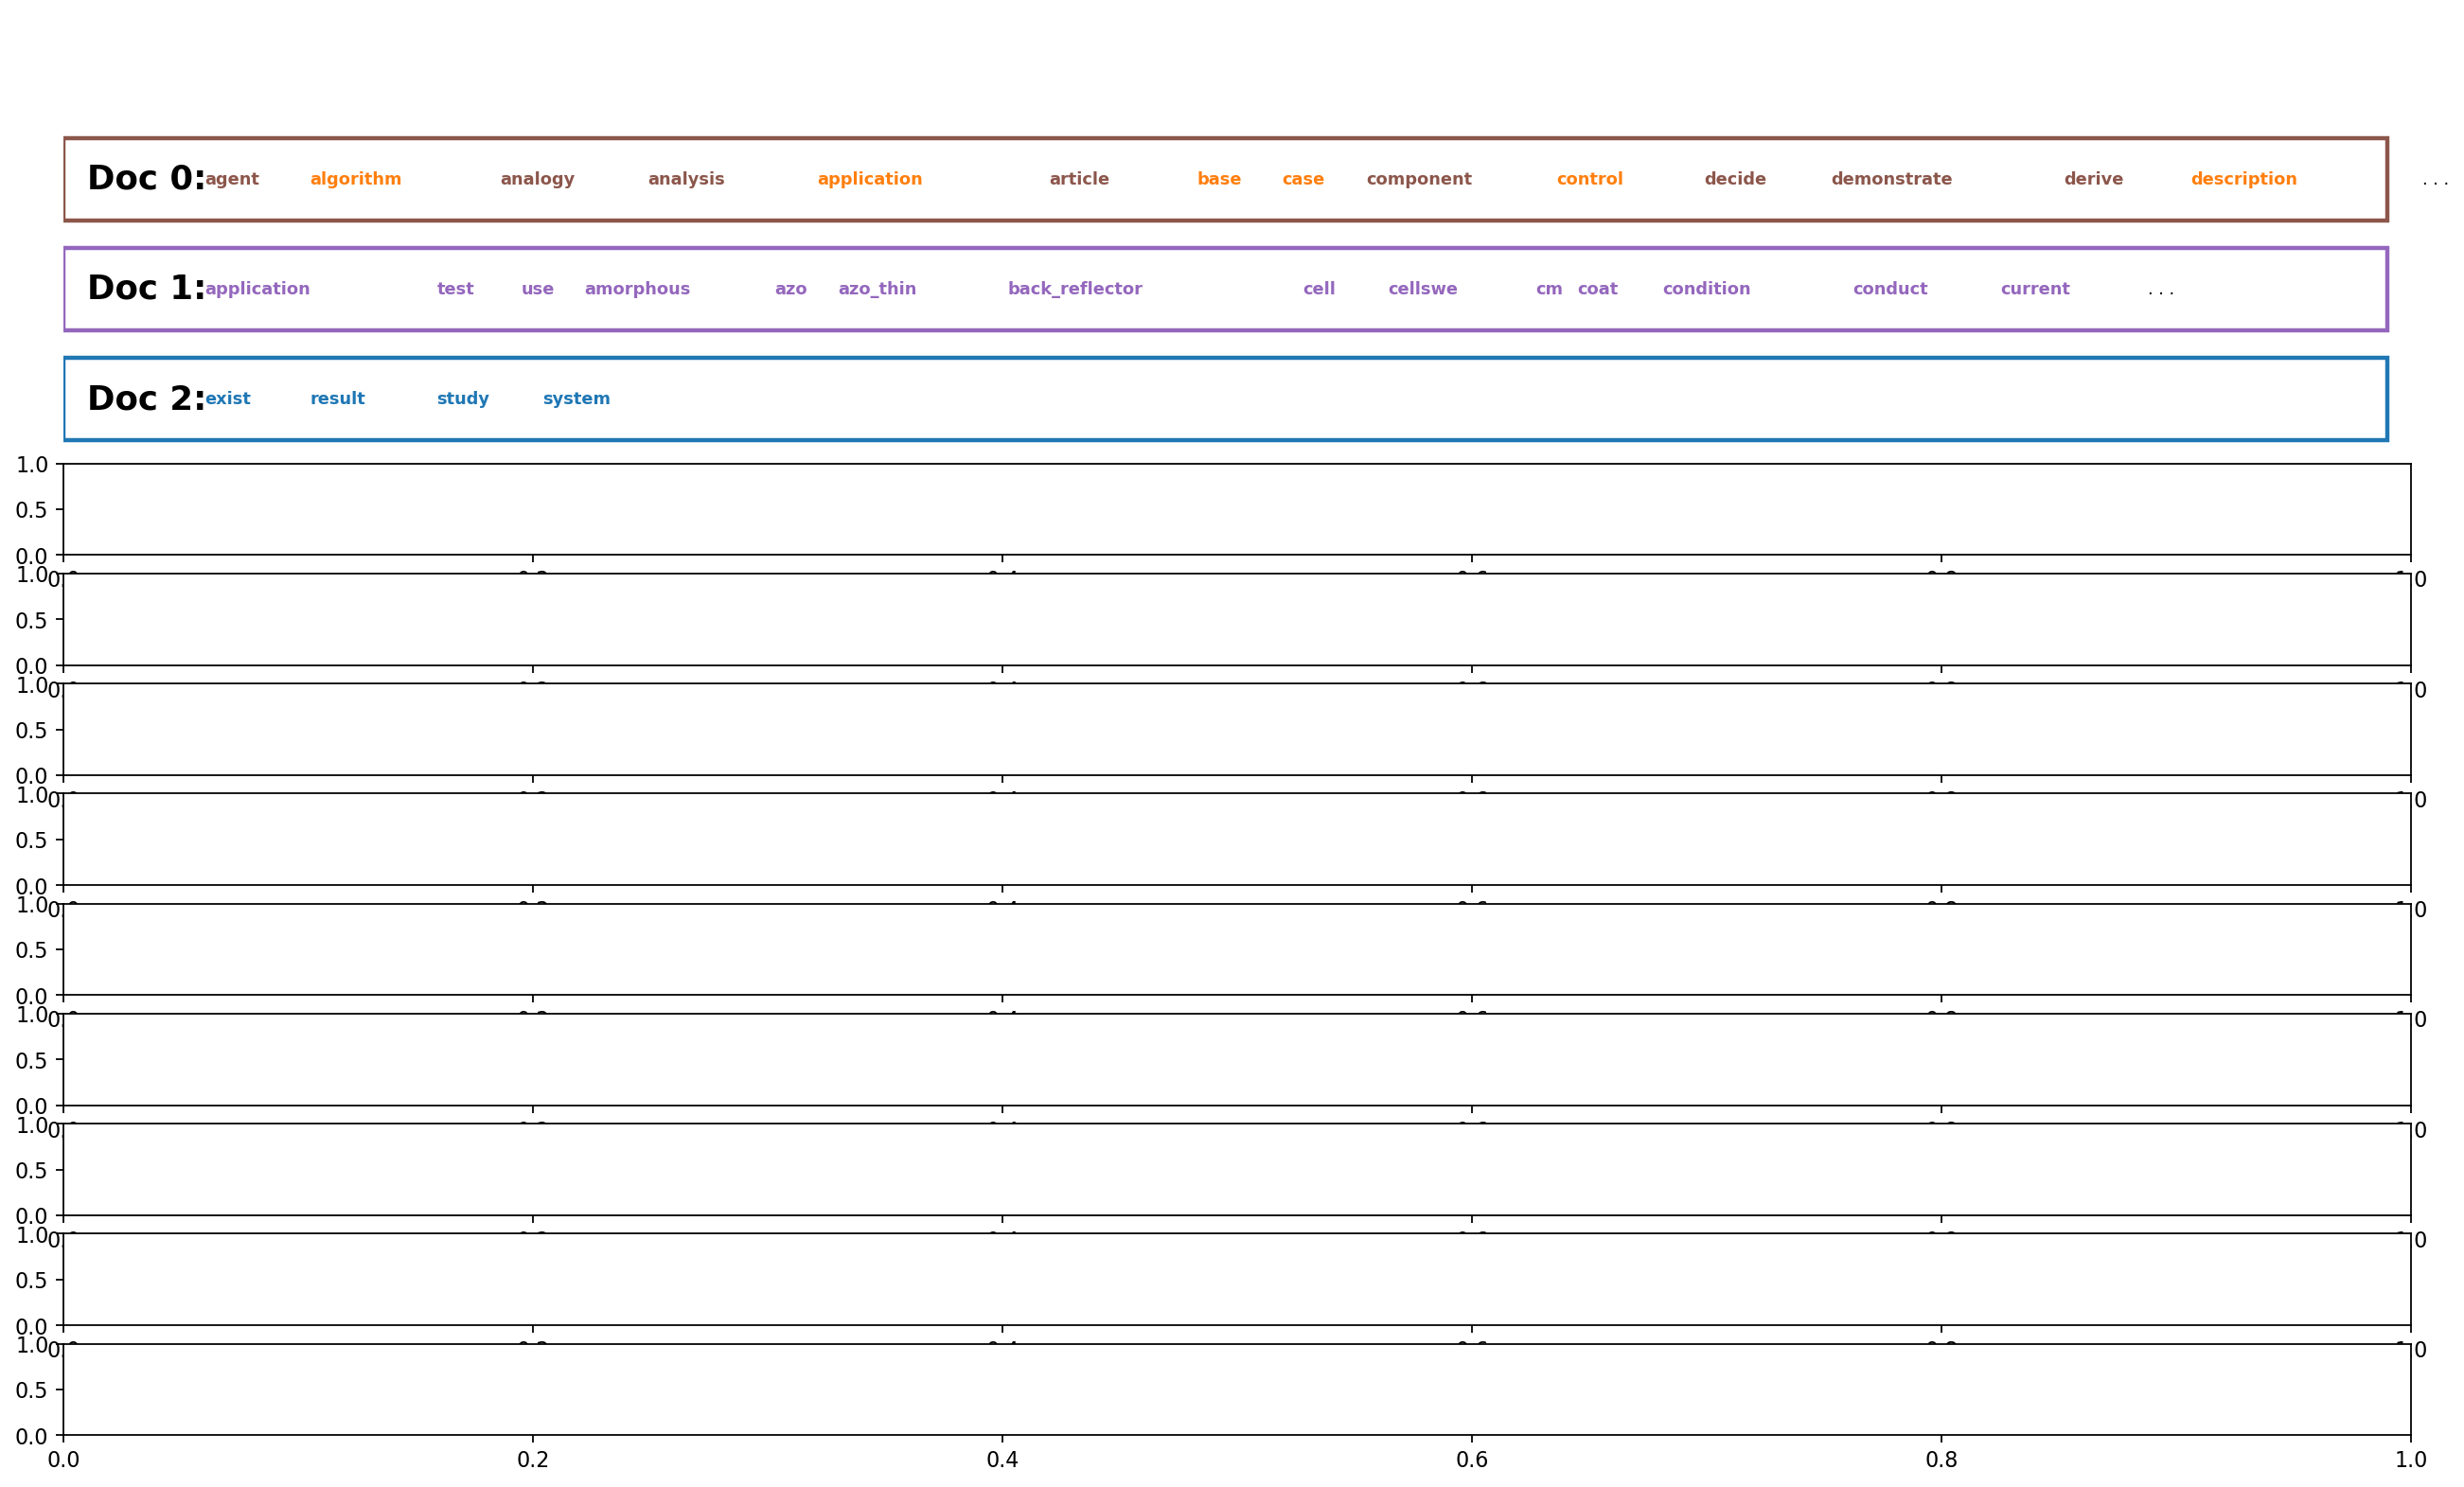

In [44]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=8, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=8, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    

In [46]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

In [48]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()


IndexError: index 0 is out of bounds for axis 0 with size 0

<Figure size 1200x480 with 2 Axes>

In [49]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 328 samples in 0.095s...
[t-SNE] Computed neighbors for 328 samples in 0.083s...
[t-SNE] Computed conditional probabilities for sample 328 / 328
[t-SNE] Mean sigma: 0.200727
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.606770
[t-SNE] KL divergence after 1000 iterations: 0.360520


Loading BokehJS ...

IndexError: index 12 is out of bounds for axis 1 with size 10

In [50]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

C:\Users\ADMIN\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.178746  0.011444       1        1  15.648794
6     -0.210062  0.058042       2        1  12.059605
0     -0.190824  0.049933       3        1  10.457817
13    -0.107834 -0.178428       4        1   8.359514
11    -0.014638  0.086884       5        1   8.237813
9     -0.033243  0.078857       6        1   6.834296
14     0.050115 -0.062823       7        1   6.207615
8      0.010615 -0.183120       8        1   5.414116
1      0.135223 -0.095060       9        1   5.153467
7      0.093686 -0.102301      10        1   4.996147
12     0.089568  0.145495      11        1   4.430278
5     -0.017201  0.023113      12        1   4.351602
3      0.079368  0.025881      13        1   3.307638
10     0.163967  0.082156      14        1   2.352235
2      0.130007  0.059926      15        1   2.189057, topic_info=     Category        Freq              Term       Total  loglift  logprob
term                                                                     
254   Default  259.000000             phase  259.000000  30.0000  30.0000
267   Default  379.000000       temperature  379.000000  29.0000  29.0000
1622  Default  157.000000          magnetic  157.000000  28.0000  28.0000
213   Default  169.000000             steel  169.000000  27.0000  27.0000
3327  Default  100.000000             creep  100.000000  26.0000  26.0000
328   Default   95.000000             plate   95.000000  25.0000  25.0000
53    Default  118.000000              test  118.000000  24.0000  24.0000
92    Default  249.000000          property  249.000000  23.0000  23.0000
359   Default   69.000000              weld   69.000000  22.0000  22.0000
2509  Default   89.000000            strain   89.000000  21.0000  21.0000
4693  Default   72.000000               jet   72.000000  20.0000  20.0000
1827  Default   78.000000          strength   78.000000  19.0000  19.0000
379   Default  109.000000               ion  109.000000  18.0000  18.0000
160   Default  160.000000          material  160.000000  17.0000  17.0000
351   Default  179.000000         structure  179.000000  16.0000  16.0000
84    Default  192.000000          increase  192.000000  15.0000  15.0000
2110  Default   71.000000            stress   71.000000  14.0000  14.0000
78    Default   95.000000              film   95.000000  13.0000  13.0000
257   Default  122.000000          pressure  122.000000  12.0000  12.0000
1201  Default  105.000000        transition  105.000000  11.0000  11.0000
199   Default   68.000000             alloy   68.000000  10.0000  10.0000
4133  Default   52.000000  ball_indentation   52.000000   9.0000   9.0000
353   Default   71.000000           thermal   71.000000   8.0000   8.0000
3167  Default   60.000000       deformation   60.000000   7.0000   7.0000
108   Default  127.000000         technique  127.000000   6.0000   6.0000
1028  Default   41.000000         evolution   41.000000   5.0000   5.0000
3095  Default   48.000000           coating   48.000000   4.0000   4.0000
1844  Default   66.000000      nanoparticle   66.000000   3.0000   3.0000
736   Default   92.000000             metal   92.000000   2.0000   2.0000
163   Default  114.000000            method  114.000000   1.0000   1.0000
...       ...         ...               ...         ...      ...      ...
2145  Topic15    6.561498          adaptive    7.571830   3.6785  -4.9838
1539  Topic15    6.481692                li    7.492022   3.6768  -4.9960
5114  Topic15    6.448516         breathing    7.458846   3.6761  -5.0012
4085  Topic15    6.204176             tribo    7.214507   3.6708  -5.0398
5113  Topic15    5.535539           breathe    6.545868   3.6541  -5.1538
5679  Topic15    5.535539        boson_peak    6.545868   3.6541  -5.1538
5133  Topic15    5.535539            wander    6.545868   3.6541  -5.1538
613   Topic15   10.425791           network   12.416632   3.6469  -4.5207
5111 

In [1]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook


In [29]:
# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

In [30]:
# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)


In [31]:
# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 328 samples in 0.001s...
[t-SNE] Computed neighbors for 328 samples in 0.154s...
[t-SNE] Computed conditional probabilities for sample 328 / 328
[t-SNE] Mean sigma: 0.200733
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.890228
[t-SNE] KL divergence after 1000 iterations: 0.361912


In [32]:
# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

Loading BokehJS ...

IndexError: index 12 is out of bounds for axis 1 with size 10